# Assignment 3 - Completing the Parameter Study 
Welcome to Course 4 Programming Assignment 3. In the previous assignments, you completed the implementation of the Lunar Lander environment and implemented an agent with neural networks and the Adam optimizer. As you may remember, we discussed a number of key meta-parameters that affect the performance of the agent (e.g. the step-size, the temperature parameter for the softmax policy, the capacity of the replay buffer). We can use rules of thumb for picking reasonable values for these meta-parameters. However, we can also study the impact of these meta-parameters on the performance of the agent to gain insight.

In this assignment, you will conduct a careful experiment analyzing performance of an agent, under different values of the step-size parameter.

**In this assignment, you will:**
 - write a script to run your agent and environment on a set of parameters, to determine performance across these parameters.
 - gain insight into the impact of the step-size parameter on agent performance by examining its parameter sensitivity curve

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
from dummy_environment import DummyEnvironment
from dummy_agent import DummyAgent

## Section 1: Write Parameter Study Script
In this section, you will write a script for performing parameter studies. You will implement the run_experiment() function. This function takes an environment and agent and performs a parameter study on the step-size and termperature parameters.


In [3]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    """
    Assume environment_parameters dict contains:
    {
        input_dim: integer,
        num_actions: integer,
        discount_factor: float
    }
    
    Assume agent_parameters dict contains:
    {
        step_size: 1D numpy array of floats,
        tau: 1D numpy array of floats
    }
    
    Assume experiment_parameters dict contains:
    {
        num_runs: integer,
        num_episodes: integer
    }    
    """
    rl_glue = RLGlue(environment, agent)
    os.system('sleep 1') 
    
    agent_sum_reward = np.zeros((len(agent_parameters["tau"]), len(agent_parameters["step_size"]),
                                 experiment_parameters["num_runs"], experiment_parameters["num_episodes"]))
    
    for i in tqdm(range(len(agent_parameters["tau"]))):
        for j in range(len(agent_parameters["step_size"])):
            env_info = {}
            
            agent_info = {"num_actions": environment_parameters["num_actions"],
                          "input_dim": environment_parameters["input_dim"],
                          "discount_factor": environment_parameters["discount_factor"],
                          "tau": agent_parameters["tau"][i],
                          "step_size": agent_parameters["step_size"][j]}
            
            for run in range(experiment_parameters["num_runs"]):
                agent_info["seed"] = agent_parameters["seed"] * experiment_parameters["num_runs"] + run
                
                rl_glue.rl_init(agent_info, env_info)
                
                for episode in range(experiment_parameters["num_episodes"]): 
                    rl_glue.rl_episode(0)
                    agent_sum_reward[i, j, run, episode] = rl_glue.rl_agent_message("get_sum_reward")
                    
            if not os.path.exists('results'):
                    os.makedirs('results')
                    
            save_name = "{}".format(rl_glue.agent.name).replace('.','')
            
            np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)

In [4]:
experiment_parameters = {
    "num_runs" : 100,
    "num_episodes" : 100,
}

# Environment parameters
environment_parameters = {
    "input_dim" : 8,
    "num_actions": 4, 
    "discount_factor" : 0.99
}

agent_parameters = {
    "step_size": 3e-5 * np.power(2.0, np.array([-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])),
    "tau": np.array([0.001, 0.01, 0.1, 1.0]),
    "seed": 0
}

test_env = DummyEnvironment
test_agent = DummyAgent

run_experiment(test_env, 
               test_agent, 
               environment_parameters, 
               agent_parameters, 
               experiment_parameters)

sum_reward_dummy_agent = np.load("results/sum_reward_dummy_agent.npy")
sum_reward_dummy_agent_answer = np.load("asserts/sum_reward_dummy_agent.npy")
assert(np.allclose(sum_reward_dummy_agent, sum_reward_dummy_agent_answer))

print("Passed the assert!")

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:06<00:00,  1.66s/it]

Passed the assert!


## Section 2: The Parameter Study for the Agent with Neural Network and Adam Optimizer
Now that you implemented run_experiment() for a dummy agent, let’s examine the performance of the agent that you implemented in Assignment 2 for different values of the step-size parameter. To do so, we can use parameter sensitivity curves. As you know, in parameter sensitivity curves, on the y-axis, we have our performance measure and on the x-axis, we have the values of the parameter we are testing. We will use the average of returns over episodes, averaged over 30 runs as our performance metric.

Recall that we used a step-size of 10^{-3}$ in Assignment 2 and got reasonable performance. We can use this value to construct a sensible set of step-sizes for our parameter study by multiplying it with powers of two:

$10^{-3} \times 2^x$ where $x \in \{-9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3\}$

We use powers of two because doing so produces smaller increments in the step-size for smaller step-size values and larger jumps for larger step-sizes.

Let’s take a look at the results for this set of step-sizes.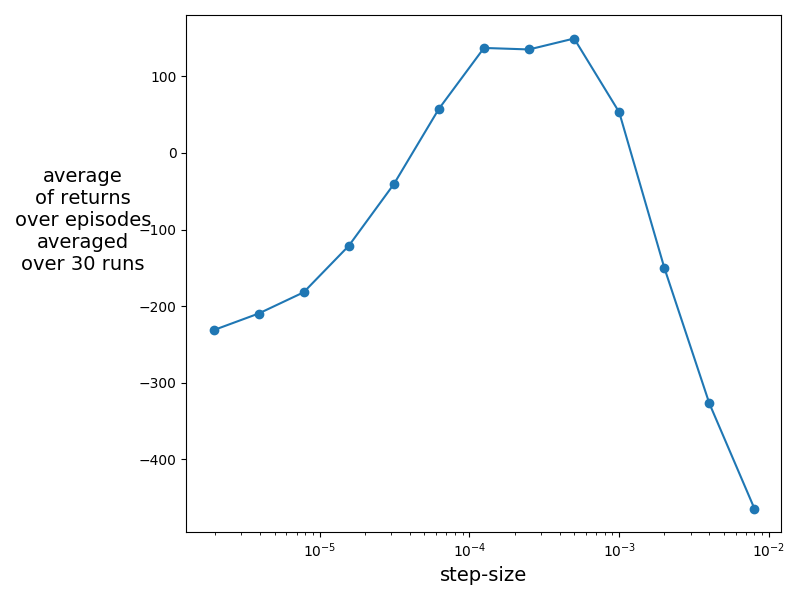

Observe that the best performance is achieved for step-sizes in range $[10^{-4}, 10^{-3}]$. This includes the step-size that we used in Assignment 2! The performance degrades for higher and lower step-size values. Since the range of step-sizes for which the agent performs well is not broad, choosing a good step-size is challenging for this problem.

As we mentioned above, we used the average of returns over episodes, averaged over 30 runs as our performance metric. This metric gives an overall estimation of the agent's performance over the episodes. If we want to study the effect of the step-size parameter on the agent's early performance or final performance, we should use different metrics. For example, to study the effect of the step-size parameter on early performance, we could use the average of returns over the first 100 episodes, averaged over 30 runs. When conducting a parameter study, you may consider these for defining your performance metric!